In [6]:
import os
import h5py
import numpy as np

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_euclidean_space, save_space_plot, plot_SO3_space
from IPython.display import Image
from cryoem.angle_recovery import train_angle_recovery

import tensorflow as tf
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays
from cryoem.angle_recovery import geodesic_distance, update_angles, distance_difference, find_best_rotation

In [7]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [8]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [9]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [10]:
projections = data['Projections']

In [11]:
projections[0].shape

(275, 275)

In [12]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles.npy")

In [13]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [16]:
from cryoem.plots import plot_images

In [18]:
plot_images(angles_true, projections, indices=range(10),img_size_scale=0.1)

In [13]:
display(ipv.screenshot())

Output()

In [13]:
!pip install utm

  Stored in directory: /home/jelena/.cache/pip/wheels/22/85/c2/314ffed39b8e02ca623e9b7d2ad7fcf3f8544a0e77c096be76
Successfully built utm
You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
!pip install astropy

    100% |████████████████████████████████| 6.5MB 5.0MB/s eta 0:00:01
You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [82]:
import utm
from astropy.coordinates import cartesian_to_spherical
import matplotlib.pyplot as plt
import ipyvolume as ipv
from cryoem.projections import RotationMatrix

In [182]:
def rotate_image(angles, vector):
    # create rotation matrix
    c1 = np.cos(angles[:,0]).reshape(-1,1,1)
    c2 = np.cos(angles[:,1]).reshape(-1,1,1)
    c3 = np.cos(angles[:,2]).reshape(-1,1,1)

    s1 = np.sin(angles[:,0]).reshape(-1,1,1)
    s2 = np.sin(angles[:,1]).reshape(-1,1,1)
    s3 = np.sin(angles[:,2]).reshape(-1,1,1)

    R = np.concatenate([np.concatenate([c1*c2*c3-s1*s3, c1*s3+c2*c3*s1 , -c3*s2],axis=2),\
                    np.concatenate([-c3*s1-c1*c2*s3,    c1*c3-c2*s1*s3 ,   s2*s3],axis=2),\
                    np.concatenate( [c1*s2,             s1*s2          ,   c2],axis=2)],axis=1)

    # rotate previous values
    for i, v in enumerate(vector):
        vector[i] = np.matmul(R,vector[i])

    return vector

def getXYZ2(p1, angles, projection, img_size_scale=0.05):
    #arr1 = read_png("figures/lena.png")
    #print(arr1.shape)
#     img_size_scale = 0.05
    #print(arr1.shape)
    #arr = arr1[:,:,1]
    projection = projection/np.max(projection)
    img = np.zeros((projection.shape[0], projection.shape[1], 3))
    img[:,:,0] = projection
    img[:,:,1] = projection
    img[:,:,2] = projection

    x = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[0])
    y = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[1])
    X, Y = np.meshgrid(x, y)
    x_shape = X.shape
    y_shape = Y.shape
    X = X.flatten() 
    Y = Y.flatten()
    
    Z = np.zeros(X.shape)
    vector = np.column_stack((X, Y, Z))
    rotated_vector = rotate_image(angles, vector)
    
    
    
    X = rotated_vector[:,0].reshape(x_shape)+p1[0]
    Y = rotated_vector[:,1].reshape(y_shape)+p1[1]
    Z = rotated_vector[:,2].reshape(x_shape)+p1[2]
    return X, Y, Z, img

In [260]:
def rotate_2d(angles, vector):
    # create rotation matrix

    c1 = np.cos(angles[0]).reshape(-1,1)

    s1 = np.sin(angles[0]).reshape(-1,1)

    R = np.concatenate([np.concatenate([c1, s1 ],axis=1),\
                    np.concatenate([-s1,    c1 ],axis=1)],axis=0)

    # rotate previous values
    for i, v in enumerate(vector):
        vector[i] = np.matmul(R,vector[i])

    return vector

def plot_images_equirectangular2(angles, projections,indices):
        
    def imscatter(x, y, image, ax=None, zoom=0.1):

        im = OffsetImage(image, zoom=zoom)
        x, y = np.atleast_1d(x, y)
        artists = []
        for x0, y0 in zip(x, y):
            ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()
        return artists

    arr = RotationMatrix(angles_true)#[:,:,3]
    x = arr[:,0]
    y = arr[:,1]
    z = arr[:,2]
    xx = arr[:,9]
    yy = arr[:,10]
    zz = arr[:,11]
    
    _, lat, lon = cartesian_to_spherical(x, y, z)
    lat = np.array(lat)
    lon = np.array(lon)
    _, lat2, lon2 = cartesian_to_spherical(xx, yy, zz)
    lat2 = np.array(lat2)
    lon2 = np.array(lon2)

    x1, y1, _,_ = utm.from_latlon(lat, lon)
    x1 = np.array(x1)[:len(indices)]
    y1 = np.array(y1)[:len(indices)]
    z1 = np.ones(x1.shape)
#     x2, y2, _,_ = utm.from_latlon(lat2, lon2)
#     x2 = np.array(x2)[:len(indices)]
#     y2 = np.array(y2)[:len(indices)]
#     z2 = np.ones(x2.shape)
    

    ipv.figure(width=500, height=500)
    #ipv.scatter(x1, y1, z1, marker="sphere", color="blue")
    img_size_scale = 30000
    for i in indices:
        X, Y, Z, img = getXYZ2([x1[i], y1[i], z1[i]], np.array([angles[i]]), projections[i],img_size_scale=img_size_scale)
        Z = np.ones(X.shape)
        
        center = [x1[i], y1[i]]  ####
        first = X[0][0], Y[0][0]

        dot = center[0]*first[0] + center[1]*first[1]      # dot product between [x1, y1] and [x2, y2]
        det = center[0]*first[1] - center[1]*first[0]      # determinant
        angle = np.arctan2(det, dot)  # atan2(y, x) or atan2(sin, cos)

        # get vector of the image and rotate it
        # new coordinates are input to plot_surface
        projection = projections[i]/np.max(projections[i])
        img = np.zeros((projection.shape[0], projection.shape[1], 3))
        img[:,:,0] = projection
        img[:,:,1] = projection
        img[:,:,2] = projection
        x = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[0])
        y = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[1])
        X, Y = np.meshgrid(x, y)
        x_shape = X.shape
        y_shape = Y.shape
        X = X.flatten() 
        Y = Y.flatten()

        vector = np.column_stack((X, Y))
        rotated_vector = rotate_2d(np.array([angle]), vector)
        
        X = rotated_vector[:,0].reshape(x_shape)+center[0]
        Y = rotated_vector[:,1].reshape(y_shape)+center[1]
    
        ipv.plot_surface(X, Y, Z, color=img)

    #ipv.zlim(-0.1,0.1)
    ipv.show()

In [262]:
plot_images_equirectangular2(angles_true, projections, indices=range(100))

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from matplotlib._png import read_png


def plot_images_equirectangular(angles_true, projections):
        
    def imscatter(x, y, image, ax=None, zoom=0.1):

        im = OffsetImage(image, zoom=zoom)
        x, y = np.atleast_1d(x, y)
        artists = []
        for x0, y0 in zip(x, y):
            ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()
        return artists
    
    arr = RotationMatrix(angles_true)#[:,:,3]
    x = arr[:,0]
    y = arr[:,1]
    z = arr[:,2]
    
    _, lat, lon = cartesian_to_spherical(x, y, z)
    lat = np.array(lat)
    lon = np.array(lon)
    
    x1, y1, _,_ = utm.from_latlon(lat, lon)

    x1 = np.array(x1)
    y1 = np.array(y1)
    
    fig, ax = plt.subplots(figsize=(20,10))
    for i1, i2, img in zip(x1[:10], y1[:10], projections[:10]):
        imscatter(i1,i2,img,ax=ax)
        ax.scatter(i1, i2, marker="o", color="blue")
    plt.show()

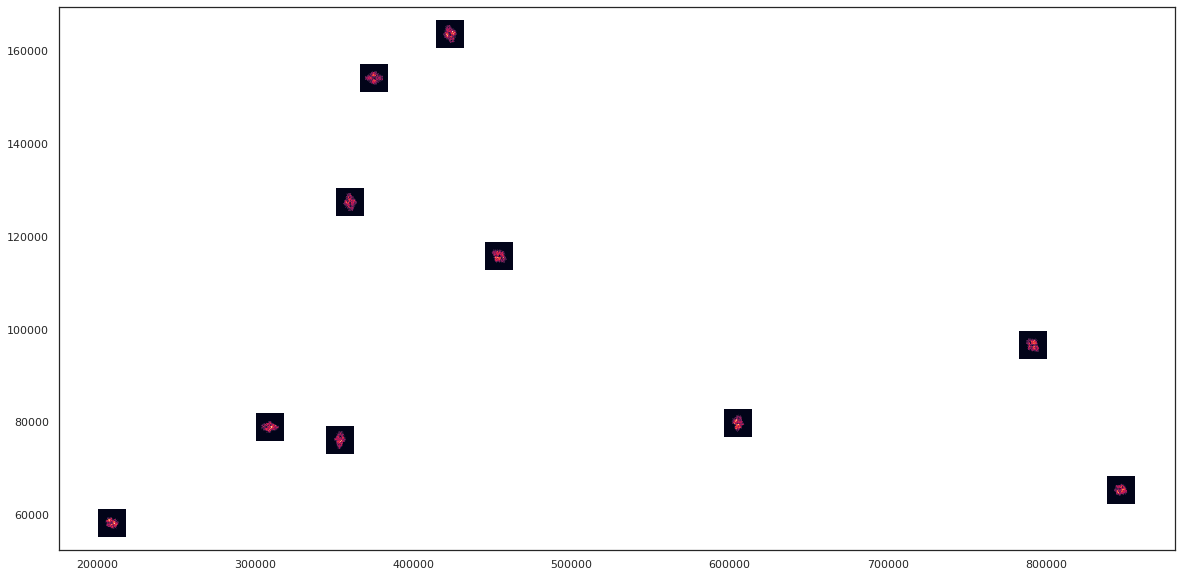

In [94]:
plot_images_equirectangular(angles_true, projections)